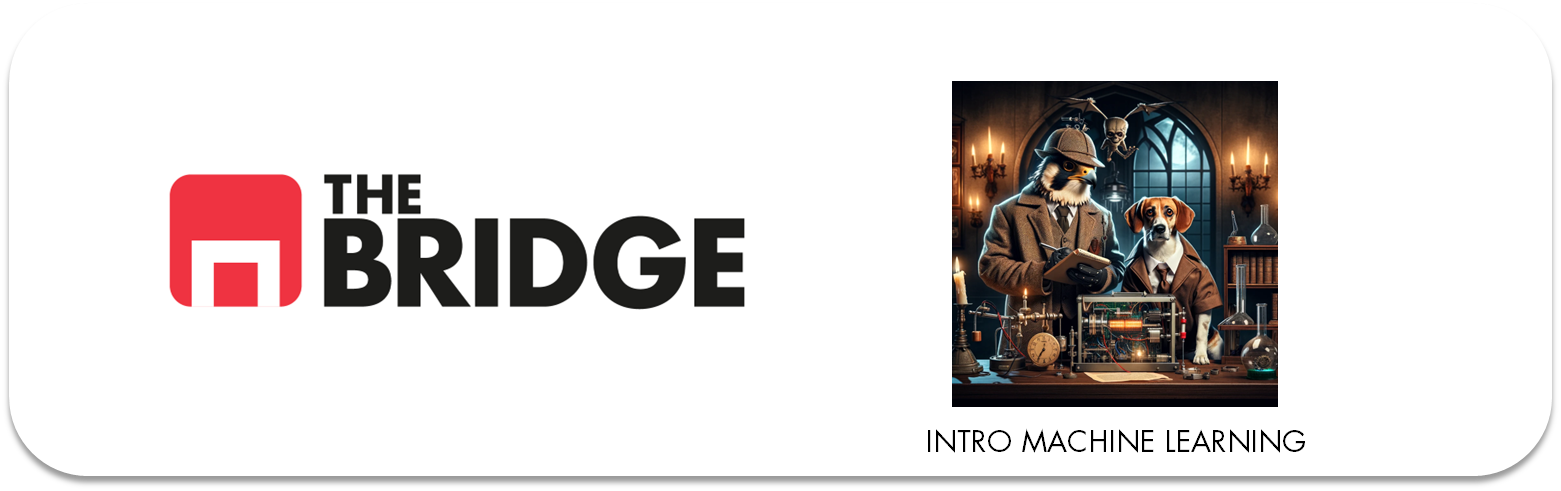

*NOTA: [Adaptado de "Hands-On Machine Learning with Scikit-Learn, Kera, and Tensorflow" de Aurelien Geron]*

## ML INTRO PRACTICA (II): EDA

In [1]:
# Recuperemos lo hecho en la sesión anterior

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from bootcampviztools import pinta_distribucion_categoricas, plot_categorical_numerical_relationship, plot_grouped_histograms
from sklearn.model_selection import train_test_split


# Código extra para los tamaños de las fuentes y los "ticks" de los ejes, esto no lo vimos al hablar de matplotlib así que una extra
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


df_inmo = pd.read_csv("./data/ejemplo_housing.csv")

train_set, test_set = train_test_split(df_inmo, test_size=0.2, random_state=42)

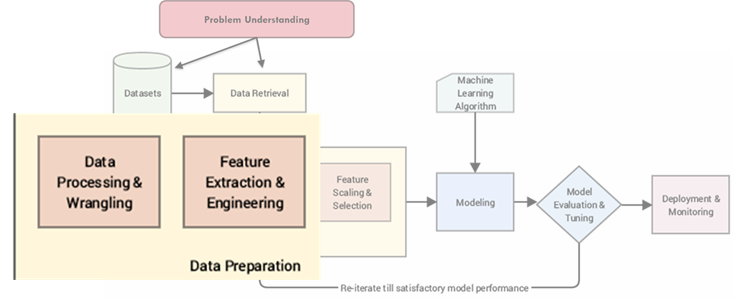

### 1. Limpieza y transformación

Deberíamos acometer la limpieza y transformación, pero como ya vimos no hay valores nulos y los datos parecen bastante limpios

In [2]:
df_inmo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20433 entries, 0 to 20432
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Unicamente parece interesante convertir "mean_income" en una variable categórica, porque ya de por sí se ha intentado hacer un escalado con la misma. Esto es algo que ya hicimos varias veces cuando analizamos datos, recurriendo a la función `cut` de pandas. Hagámoslo:


In [3]:
train_set["income_cat"] = pd.cut(train_set["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

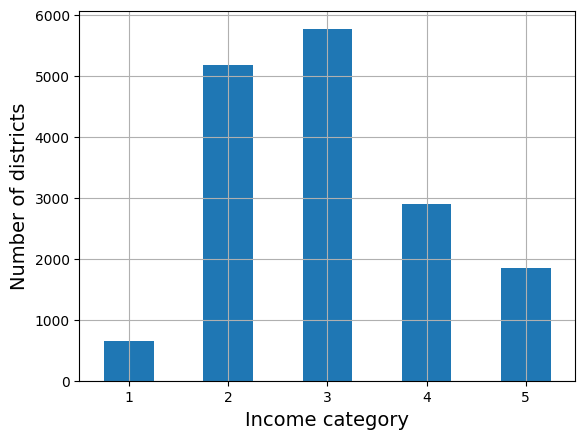

In [4]:
train_set["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

[NOTA: Importante, toda transformación que se haga en las variables de train habrá que hacerlas en los datos de test antes de poder aplicarles el modelo]

### 2. Análisis univariante

En un proceso estricto y formal de ML ahora haríamos el análisis univariante de todas las variables. Por simplicidad vamos a repetir únicamente el código para ver las distribuciones de las numéricas y las frecuencias de las categóricas:

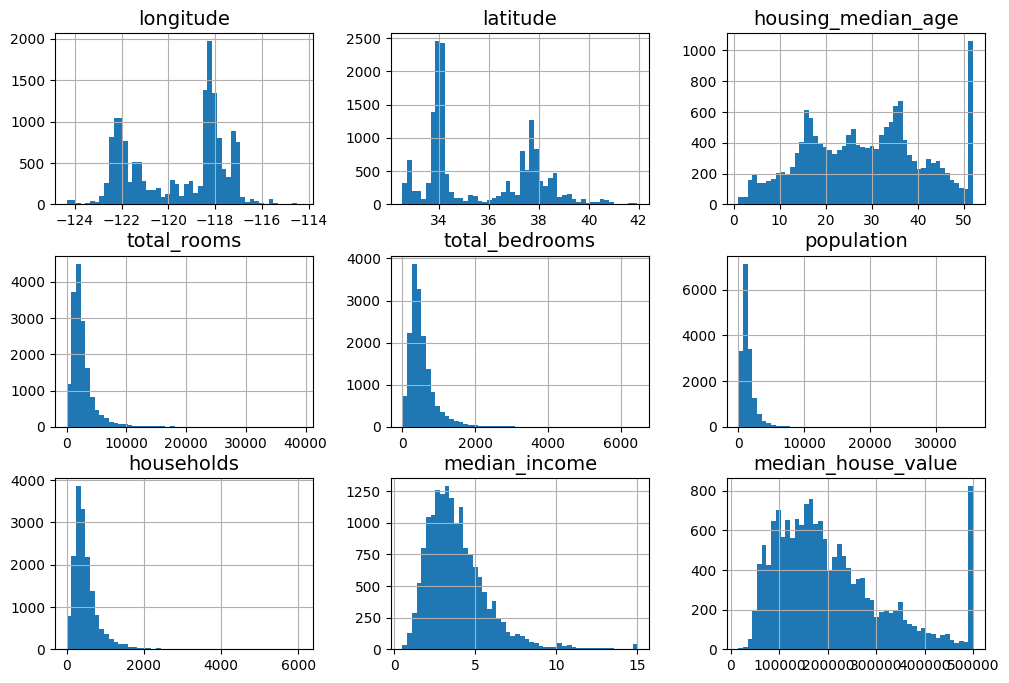

In [5]:
train_set.hist(bins=50, figsize=(12, 8)) # La forma de generar histogramas de una sola vez para las variables numéricas de un dataset
plt.show()

Y las frecuencias:


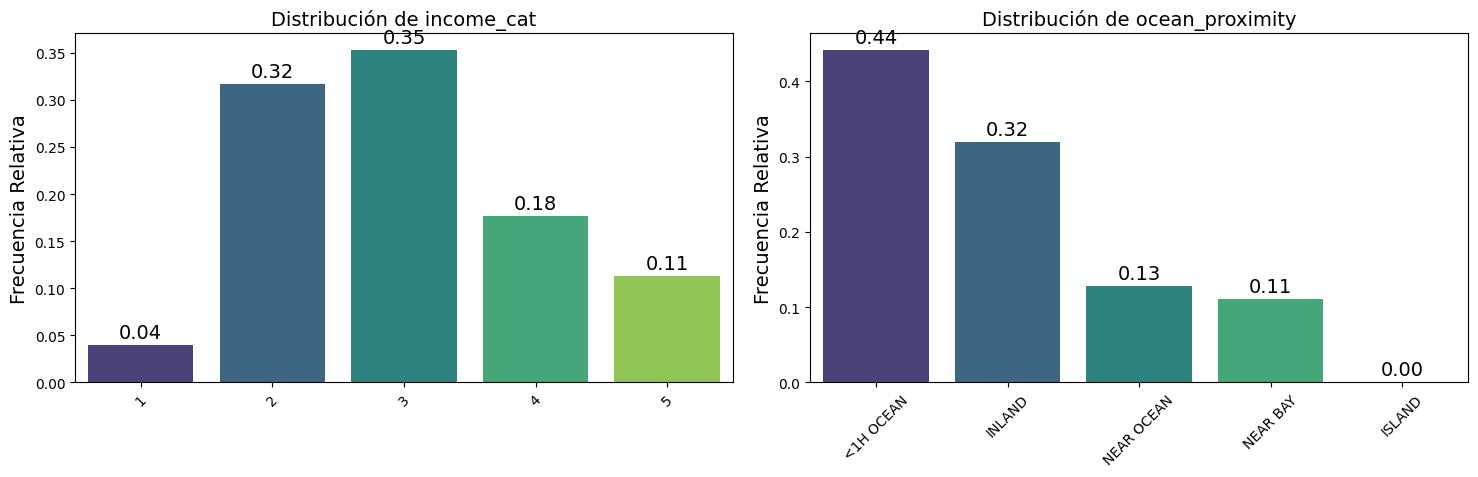

In [6]:
pinta_distribucion_categoricas(train_set, ["income_cat","ocean_proximity"], relativa= True, mostrar_valores= True)

La distribución numérica sigue las mismas pautas, como era de esperar, cuando hicimos el primer vistazo y se mantienen las mismas consideraciones. 

Respecto a las frecuencias, el income de nivel 3 es el más frecuente, el income de nivel 1 el menor y que la mayoría de las zonas no son costeras y además que apenas hay zonas en islas.

No podemos forzar más y tampoco lo necesitamos. Lo realmente importante es ver algunas combinaciones y el bivariante con el target "mean_house_value", eso sí también tendremos que decidir que hacer con los "capados" de esta y de la variable "housing_median_age".

### 2. Análisis Multivariante

#### 2.1 Variables Categóricas vs Target

Empecemos con la proximidad al océano: 

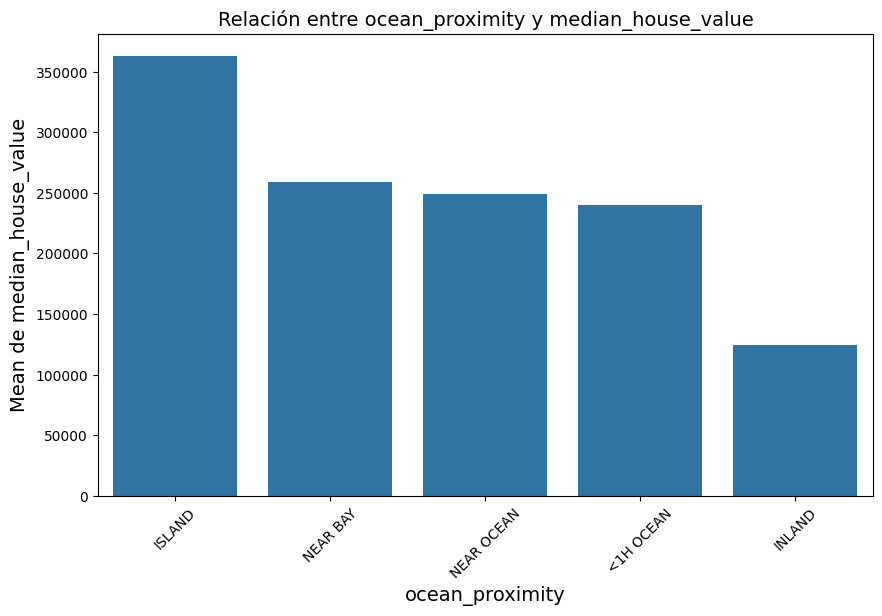

In [7]:
plot_categorical_numerical_relationship(train_set, categorical_col= "ocean_proximity", numerical_col="median_house_value")

Claramente parece que hay relación entre esta variable y el target, me la quedaré como feature. Dado que tenemos los valores geográficos (latitud y longitud), podemos comprobar esta relación y además ver el bivariante con esas dos variables haciendo una visualización:

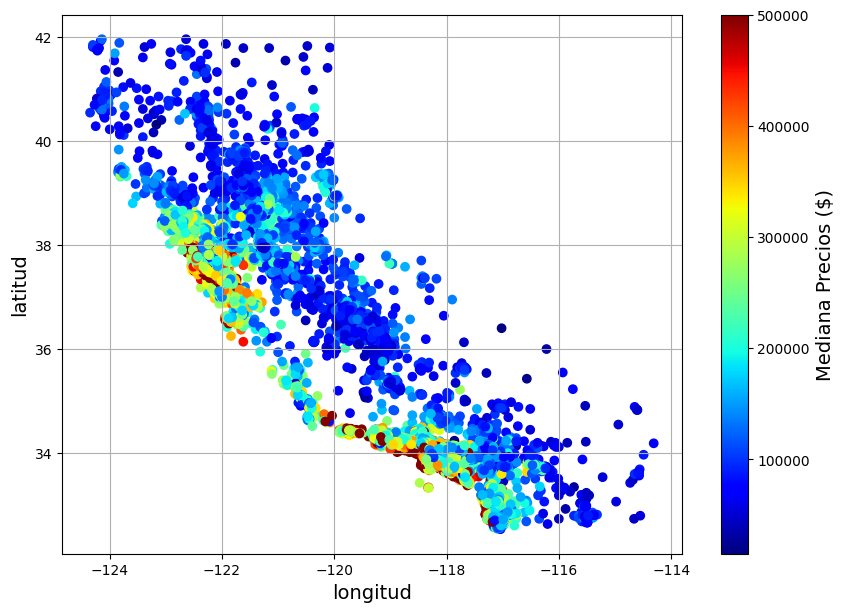

In [9]:
plt.figure(figsize=(10,7))
#cmap = jet utiliza colormap clasico azul,verde,amarillo y rojo
plt.scatter(train_set["longitude"], train_set["latitude"], c = train_set["median_house_value"], cmap = "jet")
plt.grid()
plt.xlabel("longitud")
plt.ylabel("latitud")
cbar = plt.colorbar(label = "Mediana Precios ($)")


[EXTRA: Usando pandas directamente y añadiendo la población como tamaño de la burbuja]

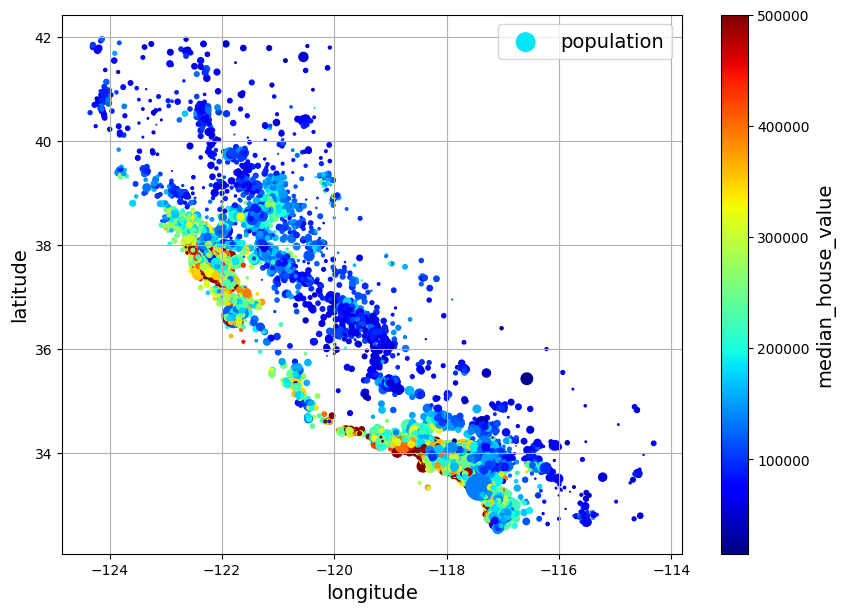

In [10]:
train_set.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=train_set["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

Seguramente podríamos hasta simplificar la variable en dos o tres valores (costero, no costero, isla). Pero no lo vamos a hacer.

c:\Users\David\OneDrive\Escritorio\git\Trabajo\DS_Online_Febr25\04_Machine_Learning\Sprint_09\Unidad_02_Introduccion_a_Machine_Learning\bootcampviztools.py:109: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(categorical_col)[numerical_col].mean()


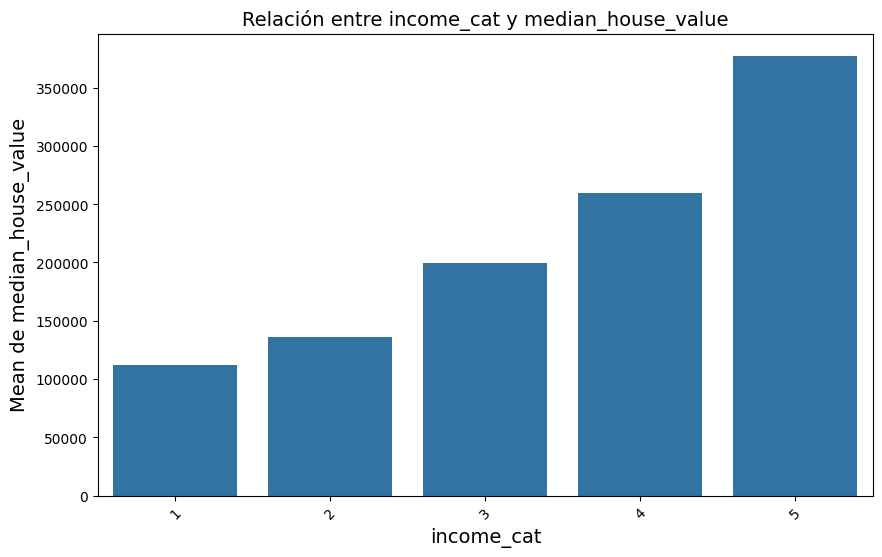

In [11]:
plot_categorical_numerical_relationship(train_set, categorical_col= "income_cat", numerical_col="median_house_value")

No hace falta decir nada no. Ahora cuando veamos las relaciones numéricas, lo veremos con el "mean_income". Esta es otra variable que nos quedaremos como feature.

#### 2.2 Variables numéricas y target

Por simplificar, directamente iremos a las correlaciones de las variables numéricas con la variable target y pintando las más significativas:

In [12]:
corr_matrix = train_set.corr(numeric_only= True)
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687342
total_rooms           0.134610
housing_median_age    0.107896
households            0.067969
total_bedrooms        0.053060
population           -0.020492
longitude            -0.046563
latitude             -0.143382
Name: median_house_value, dtype: float64

Como era de esperar "median_income" es claramente la que tiene más correlación, y podríamos descartar población y las geográficas que hemos visto que hasta cierto punto están contenidas en la categórica de cercanía al mar (quizás la latitud podríamos quedárnosla)

In [14]:
corr_matrix["median_house_value"]

longitude            -0.046563
latitude             -0.143382
housing_median_age    0.107896
total_rooms           0.134610
total_bedrooms        0.053060
population           -0.020492
households            0.067969
median_income         0.687342
median_house_value    1.000000
Name: median_house_value, dtype: float64

In [15]:
columnas = corr_matrix["median_house_value"][corr_matrix["median_house_value"] > 0.07].index.to_list()
columnas

['housing_median_age', 'total_rooms', 'median_income', 'median_house_value']

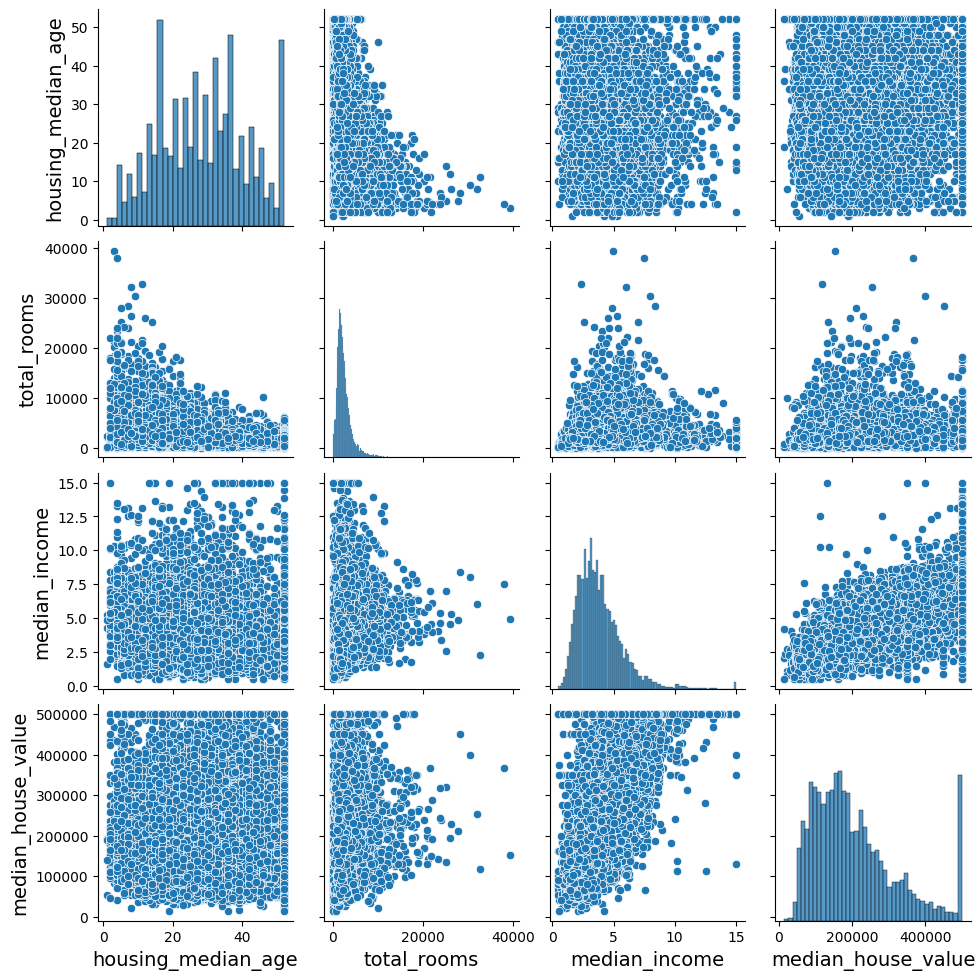

In [16]:
sns.pairplot(train_set[columnas]);

Como era de esperar gráficamente la "posible" correlación más potente es con "median_income". Pero en este caso no vamos a descartar las otras, y nos quedaremos con la categórica en vez de con "median_income". 

### 2.3 Crear otras variables

En este caso, podríamos pensar que quizás algunas variables combinadas puedan ser interesantes por ejemplo:  
1. El número medio de habitaciones por casa ("total_rooms"/"households")  
2. El número de dormitorios en función del total de habitaciones ("total_bedrooms"/"total_rooms")
3. O el número medio de personas por casas ("population"/"households")

Creemos estas variables y veamos su correlación con el target

In [19]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,rooms_per_house,bedrooms_ratio,people_per_house
17560,-117.96,34.00,34.0,2777.0,540.0,1954.0,522.0,4.5163,183800.0,<1H OCEAN,4,5.319923,0.194454,3.743295
2045,-122.81,38.54,12.0,2289.0,611.0,919.0,540.0,1.1553,139300.0,<1H OCEAN,1,4.238889,0.266929,1.701852
6383,-122.25,37.77,52.0,2650.0,566.0,1468.0,567.0,3.0161,215700.0,NEAR BAY,3,4.673721,0.213585,2.589065
4574,-117.98,33.86,25.0,1025.0,266.0,726.0,183.0,3.8750,137500.0,<1H OCEAN,3,5.601093,0.259512,3.967213
15118,-119.70,34.43,35.0,1402.0,369.0,654.0,385.0,2.6205,318800.0,<1H OCEAN,2,3.641558,0.263195,1.698701


In [17]:
train_set["rooms_per_house"] = train_set["total_rooms"] / train_set["households"]
train_set["bedrooms_ratio"] = train_set["total_bedrooms"] / train_set["total_rooms"]
train_set["people_per_house"] = train_set["population"] / train_set["households"]

In [18]:
corr_matrix = train_set.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687342
rooms_per_house       0.151574
total_rooms           0.134610
housing_median_age    0.107896
households            0.067969
total_bedrooms        0.053060
population           -0.020492
people_per_house     -0.021595
longitude            -0.046563
latitude             -0.143382
bedrooms_ratio       -0.252579
Name: median_house_value, dtype: float64

Hmm, interesante porque hemos encontrado una "mejor" correlación en habitaciones por casa "rooms_per_house" pero más interesante es la nueva variable ratio de dormitorios, que presenta una contraintuitiva "anticorrelación". Es decir a menor ratio de dormitorios por habitaciones mayor precio.

### 3. Lista de Features

Para terminar, hacemos nuestra lista de features [Nota: A medida que veamos algoritmos y más llegados a las redes, dejaremos que sea el modelo el que se encargue incluso de esta selección pero es bueno que lo practiquemos y lo entendamos]

1. ocean_proximity
2. income_cat
3. rooms_per_house
4. total_rooms
5. housing_median_age
6. bedrooms_ratio